In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

2024-03-04 16:00:42.586086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 16:00:42.586274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 16:00:42.789849: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modules loaded


In [2]:
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')


In [3]:
# Check the lengths of filepaths and labels
print("Before:", len(filepaths), len(labels))

# Remove excess file paths if the length doesn't match
filepaths = filepaths[:len(labels)]

# Check the lengths again to ensure they match
print("After:", len(filepaths), len(labels))

Before: 25000 5000
After: 5000 5000


In [4]:
# Concatenate data paths with labels into one dataframe
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [5]:
# Split data into train, validation, and test sets
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=123)


In [6]:
# Image data generator
batch_size = 16
img_size = (224, 224)

train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                           class_mode='categorical', batch_size=batch_size)

valid_data = valid_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                           class_mode='categorical', batch_size=batch_size)

test_data = test_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                         class_mode='categorical', batch_size=batch_size, shuffle=False)


Found 4000 validated image filenames belonging to 1 classes.
Found 500 validated image filenames belonging to 1 classes.
Found 500 validated image filenames belonging to 1 classes.


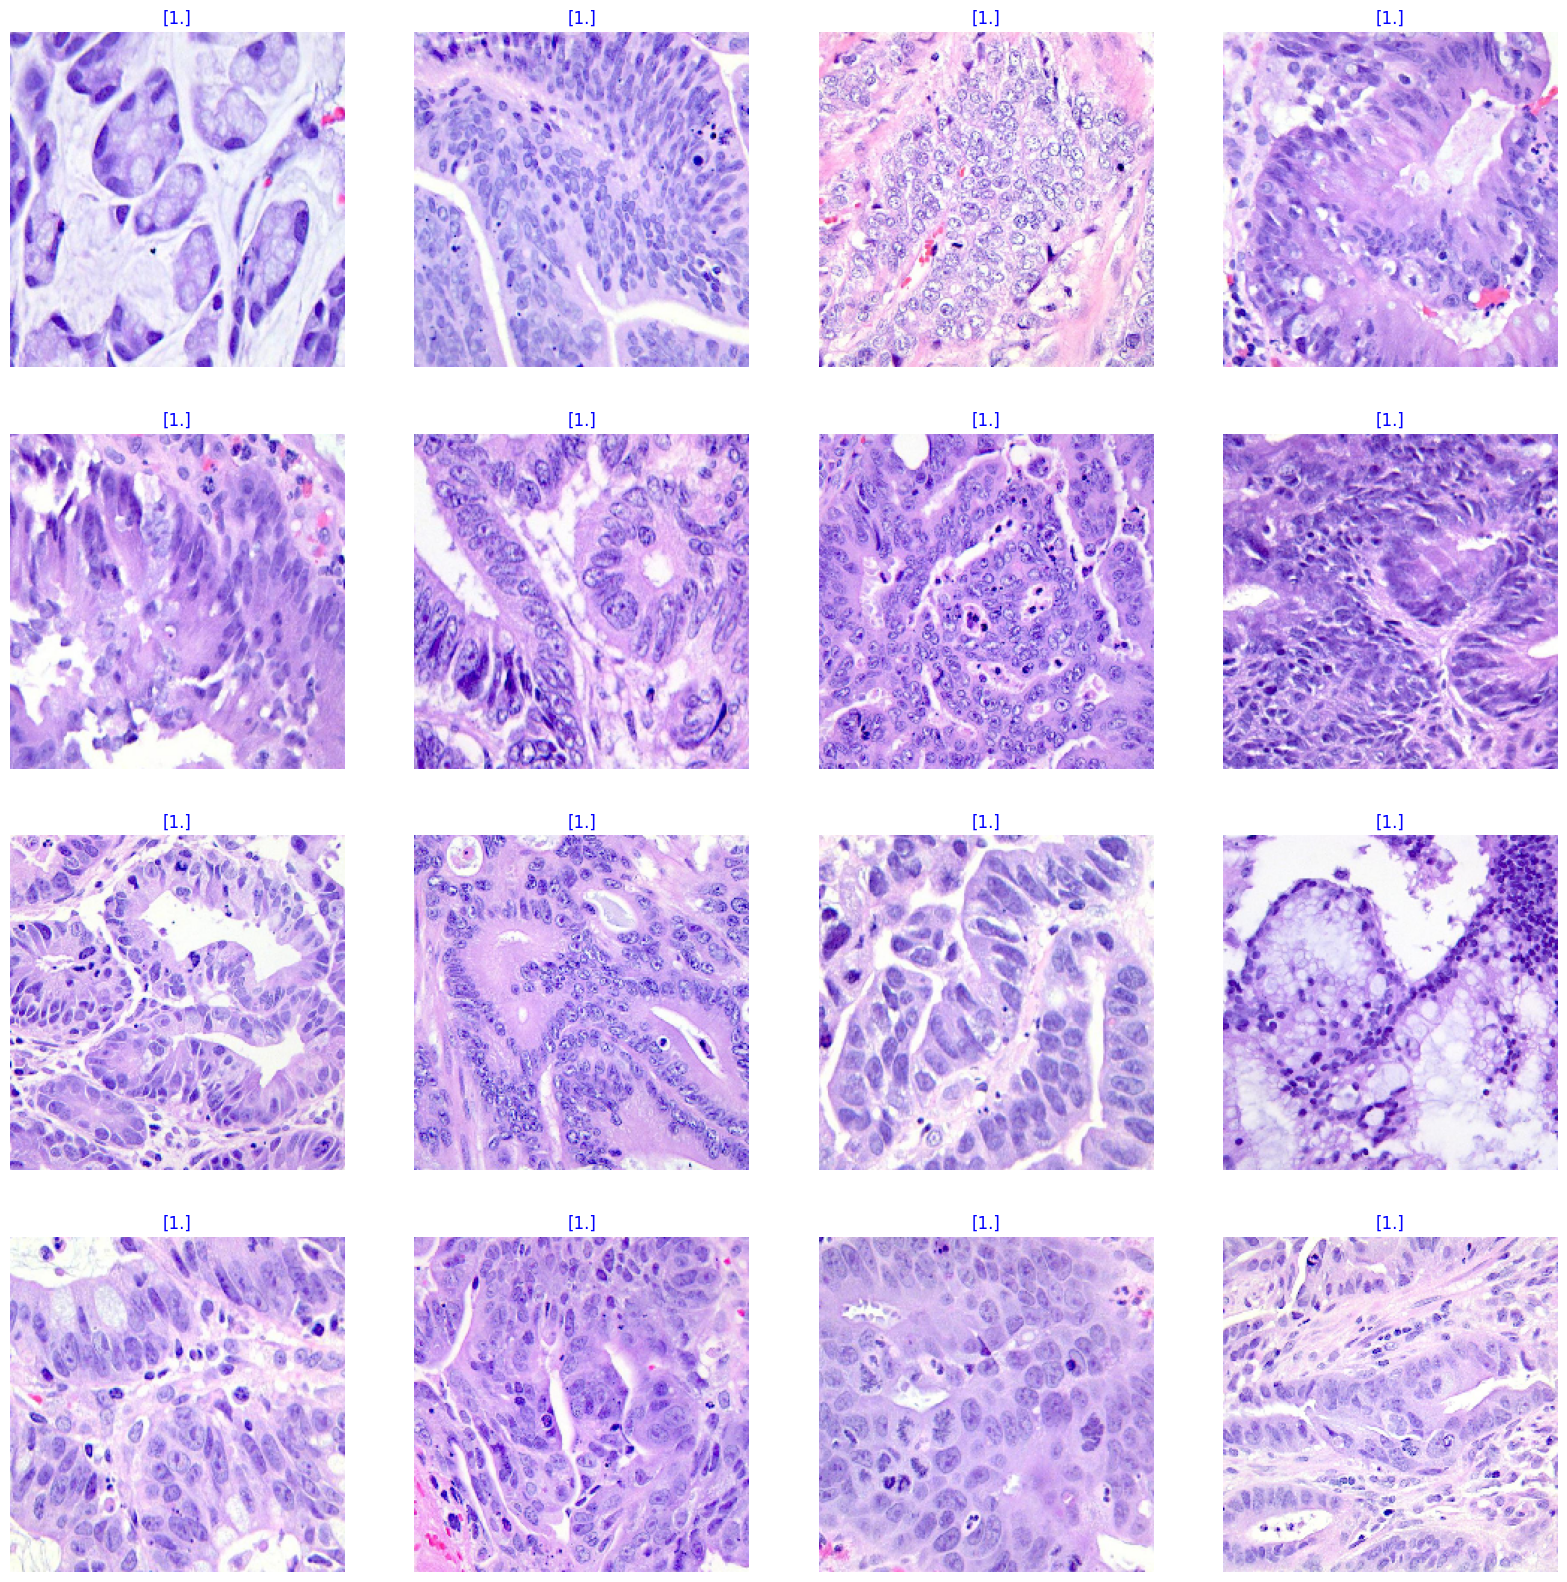

In [7]:
images, labels = next(train_data)

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i], color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adamax

# Calculate the number of classes
class_count = train_df['labels'].nunique()

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation="relu"),
    Dense(64, activation="relu"),
    Dense(class_count, activation="softmax")
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_data, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_data, steps=test_steps, verbose=1)
test_score = model.evaluate(test_data, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 1.0000 - loss: 0.0000e+00
Train Loss:  0.0
Train Accuracy:  1.0
--------------------
Valid Loss:  0.0
Valid Accuracy:  1.0
--------------------
Test Loss:  0.0
Test Accuracy:  1.0
